# Load And Train



In [3]:
import copy
import datetime
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

from xgboost import XGBClassifier, plot_importance

from src.train.utils import build_numpy, fetch_file_list


X_COLUMNS = slice(7, 76)
Y_COLUMNS = 0
np.random.seed(100)


TRAINING_DATA_DIR = './trainData/unNormed/'
VALIDATION_DATA_DIR = './validationData/unNormed/'

TRAIN_PORTION = 0.2
VALIDATION_PORTION = 1.1
MODEL_CHECKPOINT = '/Users/lucindazhao/strava/ml-local/snapshots/'
LOG_DIR = '/Users/lucindazhao/strava/ml-local/logs/'

XGBOOST_POSITIVE_WEIGHT = 10
IS_CSV = False

Using TensorFlow backend.


## Model Training

In [125]:
train_file_list = fetch_file_list(data_dir=TRAINING_DATA_DIR, portion=TRAIN_PORTION)
tg = build_numpy(file_list=train_file_list, num_samples=None, xcolumns=X_COLUMNS, ycolumns=Y_COLUMNS, ytx=None,
                 skip_header=1, shuffle=False, is_csv=IS_CSV)
val_file_list = fetch_file_list(data_dir=VALIDATION_DATA_DIR, portion=VALIDATION_PORTION)
vg = build_numpy(file_list=val_file_list, num_samples=None, xcolumns=X_COLUMNS, ycolumns=Y_COLUMNS, ytx=None,
                 skip_header=1, shuffle=False, is_csv=IS_CSV)

x_train = copy.deepcopy(tg[0])
y_train = copy.deepcopy(tg[1].reshape(-1))
x_val = copy.deepcopy(vg[0])
y_val = copy.deepcopy(vg[1].reshape(-1))
del tg
del vg

count = np.sum(y_train)
print("Number of Positive Training Windows: {}".format(count))
print("Number of Negative Training Windows: {}".format(len(y_train) - count))
eval_set = [(x_train, y_train), (x_val, y_val)]


Number of Files: 3
Number of Files: 1
Number of Positive Training Windows: 159623.0
Number of Negative Training Windows: 1765543.0


In [ ]:
import pandas as pd

import xgboost as xgb
from tensorboard_logger import configure, log_value
from sklearn.cross_validation import train_test_split


def logspy(env):
    log_value("train", env.evaluation_result_list[0][1], step=env.iteration)
    log_value("val", env.evaluation_result_list[1][1], step=env.iteration)


configure("logs/sample-1234")

boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)

x1, x2, y1, y2 = train_test_split(
    df, boston.target, test_size=0.1, random_state=18)

dtrain = xgb.DMatrix(x1, y1)
dvalid = xgb.DMatrix(x2, y2)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

model = xgb.train(
    params={},
    num_boost_round=100,
    dtrain=dtrain,
    evals=watchlist,
    callbacks=[logspy])

In [223]:


my_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_by_level=1,
                         colsample_bynode=1, colsample_bytree=0.8,
                         gamma=10, learning_rate=1.1,
                         ax_delta_step=0, max_depth=7,
                         min_child_weight=7, missing=-100,
                         n_estimators=100, n_jobs=4, nthread=4,
                         objective='binary:logistic', random_state=0,
                         reg_alpha=0, reg_lambda=1,
                         scale_pos_weight=XGBOOST_POSITIVE_WEIGHT,
                         seed=1234, subsample=0.8,
                         verbosity=2, tree_method='hist')
print(my_model.get_xgb_params())
# logloss here equivalent to CategoricalCrossEntropy in tensorflow
trained = my_model.fit(x_train, y_train, early_stopping_rounds=5,
                 # last one is used for early stopping
                 eval_metric=["error", "logloss"],
                 eval_set=eval_set, verbose=True)

key = "xgboost-unNormed-withWeight10-lr1.1-gamma10-mcw7-depth7"
file_path = MODEL_CHECKPOINT + key + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print(file_path)
# trained.save_model(file_path)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 10, 'learning_rate': 1.1, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 7, 'missing': -100, 'n_estimators': 100, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 10, 'seed': 1234, 'subsample': 0.8, 'verbosity': 2, 'colsample_by_level': 1, 'ax_delta_step': 0, 'tree_method': 'hist'}
[14:31:27] INFO: src/learner.cc:215: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[14:31:38] INFO: src/tree/updater_quantile_hist.cc:63: Generating gmat: 9.19647 sec
[14:31:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 2 pruned nodes, max_depth=7
[0]	validation_0-error:0.304062	validation_0-logloss:0.50383	validation_1-error:0.316977	validation_1-logloss:0.520406
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early

KeyboardInterrupt: 

# Plot Model Performance

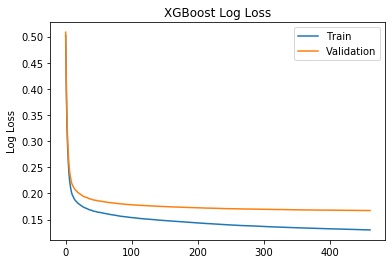

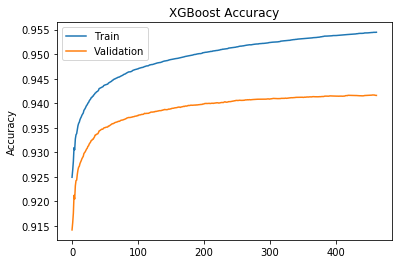

XGBClassifier(ax_delta_step=0, base_score=0.5, booster='gbtree',
              colsample_by_level=1, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8, gamma=10, learning_rate=0.3,
              max_delta_step=0, max_depth=7, min_child_weight=7, missing=-100,
              n_estimators=1000, n_jobs=4, nthread=4,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=1234, silent=None,
              subsample=0.8, tree_method='hist', verbosity=2)


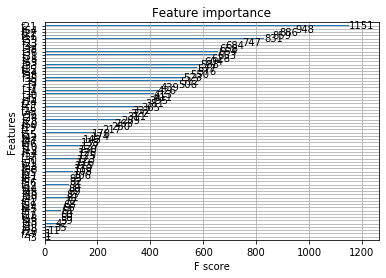

In [162]:
model = trained

results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# plot accuracy
fig, ax = plt.subplots()
ax.plot(x_axis, 1 - np.array(results['validation_0']['error']), label='Train')
ax.plot(x_axis, 1 - np.array(results['validation_1']['error']), label='Validation')
ax.legend()
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy')
plt.show()

print(model)
plot_importance(model)
plt.show()

## Load and Score


In [28]:
file_path = '/Users/lucindazhao/strava/ml-local/models/V0/xgboost-noWeight20200219-124349'

In [29]:
my_booster = xgb.Booster({})  # init model
my_booster.load_model(file_path) 
# my_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, gamma=1,
#               learning_rate=0.1, max_delta_step=0, max_depth=8,
#               min_child_weight=1, missing=None, n_estimators=2000, n_jobs=4,
#               nthread=None, objective='binary:logistic', random_state=0,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234,
#               silent=None, subsample=0.8, verbosity=2)
my_model = xgb.XGBClassifier()
my_model._Booster = my_booster
xxx = my_booster.get_score(fmap='', importance_type='total_gain')
len(xxx)

68

In [54]:
import xgboost as xgb
from timeit import default_timer as timer
from src.train.utils import build_numpy_pn, build_generator_pn, fetch_file_list

TEST_DATA = './trainData/set1/'

start = timer()
test_file_list = fetch_file_list(data_dir=TEST_DATA, portion=0.2)

tg = build_numpy(file_list=test_file_list, num_samples=None,
                 xcolumns=X_COLUMNS, ycolumns=Y_COLUMNS, ytx=None, is_csv=IS_CSV)
import copy

x = copy.deepcopy(tg[0])
y = copy.deepcopy(tg[1].reshape(-1))
del tg
end = timer()
print("{} min taken for generating input".format((end - start) / 60.0))




Number of Files: 6
0.3299846532657587 min taken for generating input


In [55]:
x.shape

(1925165, 69)

In [56]:
y_hat = my_model.predict_proba(x)

In [57]:
y_true = y.reshape(-1)
y_scores = y_hat[:, 1].reshape(-1)

result = np.stack([y_true, y_scores], axis=-1)

In [58]:
print(file_path)

pieces = file_path.split('/')
model_id = pieces[-1]
print(model_id)

/Users/lucindazhao/strava/ml-local/models/V0/xgboost-noWeight20200219-124349
xgboost-noWeight20200219-124349


In [59]:
np.savetxt("./result/{}_onTrainData.csv".format(model_id), result, fmt=['%1.0f', '%1.3f'],
           delimiter=',', newline='\n', header='label,score')

# Feature Importance Analysis

In [30]:
feature_name = ["COMMUTE",
"HAS_HEARTRATE",
"HAS_CADENCE",
"HAS_WATTS",
"DISTANCE",
"MOVING_TIME",
"ELAPSED_TIME",
"ELEV_GAIN",
"SPEED1",
"SPEED2",
"MAX_CADENCE",
"AVG_WATTS",
"AVG_CADENCE",
"MAX_HR",
"ELEV_HIGH",
"ELEV_LOW",
"MAX_SPEED",
"AVG_HR",
"MAX_HEARTRATE",
"MOBILE_FLAG",
"RACE_FLAG",
"STRAVA_TENURE_DAYS",
"PREVIOUS_ACTIVITIES",
"NUM_PHOTO_UPLOADS",
"WEB_30D_FEED_VIEWS",
"NUM_SEGMENTS_CREATED",
"VERIFIED_FLAG",
"PRO_FLAG",
"NUM_TIMES_ATHLETE_FLAGGED",
"speedMax",
"speedMean",
"speedStdDev",
"speedP20",
"speedMedian",
"speedP70",
"speedP90",
"speedP90OverP70",
"elevationMax",
"elevationMean",
"elevationStdDev",
"cadenceMax",
"cadenceMean",
"cadenceStdDev",
"cadenceP20",
"cadenceMedian",
"cadenceP70",
"cadenceP90",
"cadenceP90OverP70",
"hrMax",
"hrMean",
"hrStdDev",
"hrP20",
"hrMedian",
"hrP70",
"hrP90",
"hrP90OverP70",
"powerMax",
"powerStdDev",
"powerP20",
"powerMedian",
"powerP70",
"powerP90",
"powerP90OverP70",
"deltaTime",
"normedElevGain",
"log_distance",
"max_hr_ratio",
"mean_hr_ratio",
"median_hr_ratio"]

feature_idx = ['f' + str(i) for i in range(0, len(feature_name))]
feature_map = {}
for i, j in zip(feature_idx, feature_name):
    feature_map[i] = j



In [61]:
importance.keys()

dict_keys(['f19', 'f64', 'f11', 'f62', 'f34', 'f3', 'f22', 'f10', 'f5', 'f39', 'f54', 'f9', 'f41', 'f45', 'f48', 'f42', 'f8', 'f4', 'f61', 'f35', 'f36', 'f31', 'f47', 'f43', 'f37', 'f17', 'f16', 'f53', 'f60', 'f32', 'f57', 'f28', 'f50', 'f18', 'f46', 'f68', 'f59', 'f15', 'f30', 'f33', 'f38', 'f14', 'f29', 'f23', 'f0', 'f21', 'f65', 'f12', 'f13', 'f7', 'f44', 'f66', 'f25', 'f56', 'f24', 'f55', 'f6', 'f63', 'f20', 'f2', 'f49', 'f67', 'f52', 'f1', 'f58', 'f51', 'f40', 'f27'])

In [51]:
#“gain”, “weight”, “cover”, “total_gain” or “total_cover”.
# weight: In all trees, the number of times a feature is used to split a node
# total_cover: the number of all instances in a tree that are processed each time a node is split.
# cover: total_cover / weight
# total_gain: In all trees, the total gain of a feature at each split node.
# If the information before and after splitting is i0 and i1 by entropy or Gini impurity, the gain is (i0 - i1)
# gain: total_gain / weight


importance = my_model.get_booster().get_score(fmap='', importance_type='cover')

indexes = list(importance.keys())
name_array = []
importance_array = []

for idx in indexes:
    name_array.append(feature_map.get(idx))
    importance_array.append(importance.get(idx))
    


In [52]:
# sort by importance

sorted_array = sorted(zip(importance_array, name_array), reverse=True)


In [53]:
sorted_array[0:20]

[(61035.61359117662, 'RACE_FLAG'),
 (34036.16731111111, 'PRO_FLAG'),
 (10543.661743029246, 'MOBILE_FLAG'),
 (9394.844210773277, 'cadenceMax'),
 (9174.356527520544, 'HAS_WATTS'),
 (8974.85219880819, 'powerP70'),
 (8880.172644765235, 'powerP20'),
 (7839.656401513708, 'AVG_CADENCE'),
 (7543.538963732492, 'COMMUTE'),
 (6569.316642230595, 'speedStdDev'),
 (6357.7526916601855, 'powerP90OverP70'),
 (5752.2049210110545, 'cadenceMedian'),
 (5596.159693537771, 'speedP20'),
 (5380.024434205133, 'hrP70'),
 (5347.8501416543295, 'speedMean'),
 (5163.874833202041, 'MAX_CADENCE'),
 (5117.128867698952, 'powerMax'),
 (4982.082681191532, 'powerMedian'),
 (4769.792119242654, 'hrMax'),
 (4717.213442664194, 'cadenceP20')]

In [28]:

for i in range(len(sorted_array)-1, -1, -1):
    print(sorted_array[i][1] + ": " + str(sorted_array[i][0]))

MOBILE_FLAG: 1114.2735918451058
HAS_WATTS: 1033.4951186680005
powerP20: 918.9455199513701
powerP90OverP70: 918.6715677566295
COMMUTE: 630.3080040748525
hrP70: 610.9361640205555
hrP90: 535.7200192322559
AVG_CADENCE: 505.9224522417977
hrMax: 505.058946126182
AVG_WATTS: 377.6141514546722
deltaTime: 353.4829545071231
normedElevGain: 296.1809584712065
RACE_FLAG: 288.6142147839475
speedP70: 258.3399519841746
MAX_HR: 245.73647479999514
powerP90: 197.69550125149996
cadenceMax: 197.40694003917656
HAS_HEARTRATE: 194.7801976111111
powerP70: 182.8645053940842
speedP90OverP70: 169.08365683961054
HAS_CADENCE: 168.35549920000003
speedP90: 168.11323765975237
PREVIOUS_ACTIVITIES: 158.82274076646502
speedP20: 142.24918819492308
log_distance: 142.2247558472337
MOVING_TIME: 141.34473578447384
SPEED2: 141.26289219379788
powerMedian: 138.3215903807368
speedMedian: 136.3392651258143
DISTANCE: 134.77636943276156
elevationStdDev: 132.47285982976703
cadenceMean: 118.54431959723075
MAX_HEARTRATE: 112.36366720942

# Cross Validation To Double Check

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
params = {'max_depth': 6, 'n_estimators': 1200, 'eta': 0.02, 'subsample': 0.8, 'colsample_bytree': 0.8,
          'min_child_weight': 3, 'gamma': 0.1, 'scale_pos_weight': 10, 'seed': 1234,
                     'verbosity': 2, 'tree_method': 'hist'}

cv_results = xgb.cv(
    params=params, dtrain=dtrain, num_boost_round=1200, nfold=10, stratified=False, folds=None,
    metrics=('logloss', 'error'), obj=None, feval=None, maximize=False, early_stopping_rounds=100,
    fpreproc=None, as_pandas=True, verbose_eval=2, show_stdv=True,
    seed=1234, callbacks=None, shuffle=False)

In [ ]:
cv_results

# HyperParameter Search

In [65]:
# First set learning rate high and set early stop to get best # estimators

# parameters = {"base_score": 0.1, "booster": 'gbtree', "colsample_by_level": 1,
#                          "colsample_bynode": 1, "colsample_bytree": 0.8,
#                          "eta": 0.8, "learning_rate": 0.8, "gamma": 0.1, 
#                          "ax_delta_step": 0, "max_depth": 6,
#                          "min_child_weight": 3, "missing": None,
#                          "n_estimators": 10, "nthread": None, "n_jobs": 4,
#                          "objective": 'binary:logistic', "random_state": 0,
#                          "reg_alpha": 0, "reg_lambda": 1,
#                          "seed": 1234, "subsample": 0.8,
#                          "verbosity": 2, "tree_method":'hist'}

my_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_by_level=1,
                         colsample_bynode=1, colsample_bytree=0.8,
                         learning_rate=0.75, gamma=0.1, 
                         ax_delta_step=0, max_depth=6,
                         min_child_weight=3, missing=None,
                         n_estimators=2000, n_jobs=4, nthread=None,
                         objective='binary:logistic', random_state=0,
                         reg_alpha=0, reg_lambda=1,
                         scale_pos_weight=1,
                         seed=1234, subsample=0.8,
                         verbosity=2, tree_method='hist')
my_model.get_xgb_params()
# logloss here equivalent to CategoricalCrossEntropy in tensorflow
trained = my_model.fit(x_train, y_train, early_stopping_rounds=5,
                 # last one is used for early stopping
                 eval_metric=["error", "logloss"],
                 eval_set=eval_set, verbose=True)

# key = "xgboost-withClassWeight"
# file_path = MODEL_CHECKPOINT + key + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# trained.save_model(file_path)

[11:19:09] INFO: src/learner.cc:215: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[11:19:11] INFO: src/tree/updater_quantile_hist.cc:63: Generating gmat: 1.55963 sec
[11:19:11] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-error:0.432349	validation_0-logloss:0.995246	validation_1-error:0.443135	validation_1-logloss:1.02046
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 5 rounds.
[11:19:12] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-error:0.138437	validation_0-logloss:0.4599	validation_1-error:0.149279	validation_1-logloss:0.481144
[11:19:13] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-error:0.22051

In [33]:
# Fix learning rate and number of estimators for tuning sklearn

In [35]:
from sklearn.model_selection import GridSearchCV

# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

# clf = GridSearchCV(svc, parameters)
# clf.fit(iris.data, iris.target)
# GridSearchCV(estimator=SVC(),
#              param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})
# sorted(clf.cv_results_.keys())

In [148]:
# set learning_rate to 0.75 and estimators to 
param_test1 = {
 'max_depth':[5],
 'gamma': [1, 5, 8, 10, 15],
 'min_child_weight': [1, 5]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(base_score=0.5, booster='gbtree', colsample_by_level=1,
                         colsample_bynode=1, colsample_bytree=0.8,
                         gamma=0.1, learning_rate=0.7,
                         ax_delta_step=0, max_depth=8,
                         min_child_weight=3,missing=-100,
                         n_estimators=150, n_jobs=4, nthread=None,
                         objective='binary:logistic', random_state=0,
                         reg_alpha=0, reg_lambda=1,
                         scale_pos_weight=XGBOOST_POSITIVE_WEIGHT,
                         seed=1234, subsample=0.8,
                         verbosity=2, tree_method='hist'),
                        param_grid = param_test1, scoring=["accuracy", "neg_log_loss"],n_jobs=4,iid=False,
                        cv=3, refit=False, verbose=2)

gsearch1.fit(x_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/lucindazhao/strava/ml-local/env/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 24.8min finished
/Users/lucindazhao/strava/ml-local/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(ax_delta_step=0, base_score=0.5,
                                     booster='gbtree', colsample_by_level=1,
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.1,
                                     learning_rate=0.7, max_delta_step=0,
                                     max_depth=8, min_child_weight=3,
                                     missing=-100, n_estimators=150, n_jobs=4,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=1234, silent=None,
                                     subsample=0.8, tree_method='hist',
                                     verbosity=2),
             iid=False, n_jobs=4,
             param_grid={'gamma': [1, 5, 8, 10, 

In [149]:
gsearch1.cv_results_

{'mean_fit_time': array([184.55234543, 183.44084938, 178.01039171, 180.26019239,
        175.65034238, 176.95909945, 179.04701781, 179.74266092,
        175.96921539, 165.05632591]),
 'std_fit_time': array([0.62543105, 9.34673544, 1.20708283, 0.37169032, 0.62543163,
        1.20737256, 0.31068869, 0.37495029, 0.30177686, 7.83375111]),
 'mean_score_time': array([ 9.86879524, 10.19928598, 10.01265049, 10.03938627, 10.07174929,
        10.00922497,  9.85393659,  9.91008337,  9.49387598,  8.51746702]),
 'std_score_time': array([0.070983  , 0.12680132, 0.01238536, 0.07158804, 0.06427559,
        0.09560083, 0.13380809, 0.23240231, 0.09257372, 0.46805031]),
 'param_gamma': masked_array(data=[1, 1, 5, 5, 8, 8, 10, 10, 15, 15],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
              mask=[False, False, Fal

In [150]:
x = gsearch1.cv_results_['rank_test_accuracy']
for i in x[0:8]:
    idx = i - 1
    print("Index: {}".format(idx))
    print(gsearch1.cv_results_['params'][idx])
    print(gsearch1.cv_results_['mean_test_accuracy'][idx])

Index: 3
{'gamma': 5, 'max_depth': 5, 'min_child_weight': 5}
0.943050625244784
Index: 2
{'gamma': 5, 'max_depth': 5, 'min_child_weight': 1}
0.942906741548521
Index: 1
{'gamma': 1, 'max_depth': 5, 'min_child_weight': 5}
0.9429057026770679
Index: 0
{'gamma': 1, 'max_depth': 5, 'min_child_weight': 1}
0.9428880418623641
Index: 4
{'gamma': 8, 'max_depth': 5, 'min_child_weight': 1}
0.9428470064399641
Index: 6
{'gamma': 10, 'max_depth': 5, 'min_child_weight': 1}
0.9427877907671339
Index: 7
{'gamma': 10, 'max_depth': 5, 'min_child_weight': 5}
0.9428444092613312
Index: 5
{'gamma': 8, 'max_depth': 5, 'min_child_weight': 5}
0.9428044127103844


In [144]:
x = gsearch1.cv_results_['rank_test_accuracy']
for i in x[0:8]:
    idx = i - 1
    print("Index: {}".format(idx))
    print(gsearch1.cv_results_['params'][idx])
    print(gsearch1.cv_results_['mean_test_accuracy'][idx])

Index: 10
{'gamma': 10, 'max_depth': 7, 'min_child_weight': 7}
0.9436495346375325
Index: 8
{'gamma': 10, 'max_depth': 7, 'min_child_weight': 1}
0.9435321421633253
Index: 0
{'gamma': 5, 'max_depth': 7, 'min_child_weight': 1}
0.9434573434186975
Index: 1
{'gamma': 5, 'max_depth': 7, 'min_child_weight': 5}
0.9436412236659072
Index: 11
{'gamma': 10, 'max_depth': 7, 'min_child_weight': 9}
0.9437393970182312
Index: 6
{'gamma': 8, 'max_depth': 7, 'min_child_weight': 7}
0.9437305666108794
Index: 4
{'gamma': 8, 'max_depth': 7, 'min_child_weight': 1}
0.9434438380898063
Index: 2
{'gamma': 5, 'max_depth': 7, 'min_child_weight': 7}
0.9438666587712436


In [141]:
x = gsearch1.cv_results_['rank_test_accuracy']
for i in x[0:8]:
    idx = i - 1
    print("Index: {}".format(idx))
    print(gsearch1.cv_results_['params'][idx])
    print(gsearch1.cv_results_['mean_test_accuracy'][idx])

Index: 14
{'gamma': 5, 'max_depth': 7}
0.9435549973352947
Index: 5
{'gamma': 1, 'max_depth': 6}
0.9433737142667177
Index: 7
{'gamma': 1, 'max_depth': 8}
0.943164901104632
Index: 4
{'gamma': 1, 'max_depth': 5}
0.9429088192914273
Index: 13
{'gamma': 5, 'max_depth': 6}
0.9433518979662013
Index: 6
{'gamma': 1, 'max_depth': 7}
0.943496301098191
Index: 2
{'gamma': 0.1, 'max_depth': 7}
0.9433680004737255
Index: 11
{'gamma': 3, 'max_depth': 8}
0.9432999543935431


In [76]:
# Tune Gamma
# set max_depth to 8 and min_child_weight to 1
param_test1 = {
 'gamma':[0, 0.3, 1, 3, 5],
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(base_score=0.1, booster='gbtree', colsample_by_level=1,
                         colsample_bynode=1, colsample_bytree=0.8,
                         learning_rate=0.75, 
                         ax_delta_step=0, max_depth=8,
                         min_child_weight=1, missing=None,
                         n_estimators=140, n_jobs=4, nthread=None,
                         objective='binary:logistic', random_state=0,
                         reg_alpha=0, reg_lambda=1,
                         scale_pos_weight=XGBOOST_POSITIVE_WEIGHT,
                         seed=1234, subsample=0.8,
                         verbosity=2, tree_method='hist'),
                        param_grid = param_test1, scoring=["accuracy", "neg_log_loss"],n_jobs=4,iid=False,
                        cv=2, refit=False, verbose=2)

gsearch2.fit(x_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/lucindazhao/strava/ml-local/env/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  2.5min finished
/Users/lucindazhao/strava/ml-local/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(ax_delta_step=0, base_score=0.1,
                                     booster='gbtree', colsample_by_level=1,
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.75, max_delta_step=0,
                                     max_depth=8, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=4,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=10, seed=1234,
                                     silent=None, subsample=0.8,
                                     tree_method='hist', verbosity=2),
             iid=False, n_jobs=4, param_grid={'gamma': [0, 0.3, 1, 3, 5]},
       

In [77]:
gsearch2.cv_results_

{'mean_fit_time': array([45.93323338, 45.57745004, 46.93528044, 46.59894049, 42.67984092]),
 'std_fit_time': array([0.3984195 , 0.15898299, 0.04405534, 0.16289055, 0.06685007]),
 'mean_score_time': array([4.7802465 , 4.83309948, 4.77295506, 4.69449353, 3.94773555]),
 'std_score_time': array([0.02002573, 0.04510558, 0.00315511, 0.03703141, 0.01048636]),
 'param_gamma': masked_array(data=[0, 0.3, 1, 3, 5],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'gamma': 0},
  {'gamma': 0.3},
  {'gamma': 1},
  {'gamma': 3},
  {'gamma': 5}],
 'split0_test_accuracy': array([0.91757204, 0.9163254 , 0.9179024 , 0.91325866, 0.91205565]),
 'split1_test_accuracy': array([0.91691704, 0.91634358, 0.91643084, 0.91481643, 0.91034096]),
 'mean_test_accuracy': array([0.91724454, 0.91633449, 0.91716662, 0.91403755, 0.9111983 ]),
 'std_test_accuracy': array([3.27502425e-04, 9.08908994e-06, 7.35779149e-04, 7.78885678e-04,
        8.57345709

In [ ]:
# set gamma to 1, doesn't seem to play critical role
